# **Imports**

In [0]:
import numpy as np
import math  
from matplotlib import pyplot as plt
import cv2
from urllib.request import urlopen

# **Basic Image Converts and Imshow**

In [0]:
class Image(object):
  @staticmethod
  def show(img, title='image'):
    plt.imshow(img, cmap='gray')
    plt.show()
  
  @staticmethod
  def show_all(image_list, title_list):
    plt.figure(figsize=[20, 20])
    assert len(image_list) == len(title_list), "Houston we've got a problem"
    N = len(image_list)
    for index, (img, title) in enumerate(zip(image_list, title_list)):
      plt.subplot(1, N, index+1)
      if len(img.shape) != 3:
        plt.imshow(img, cmap='gray')
      else:
        plt.imshow(img)
      plt.title(title)
    plt.show()


# Defining Helper Functions for myconv and Normalized Cross Validation

In [0]:
def show_after_conv(convolved_, labels):
  convolved_gray = [norm_abs(convolved_[:, :, i]) for i in range(convolved_.shape[2])]
  Image.show_all(convolved_gray, labels)

def equals(img1, img2):
  img1 = normUINT8(img1)
  img2 = normUINT8(img2)
  boolx = np.linalg.norm((img1 - img2))
  if boolx == 0:
    print('The Images are equal')
  else:
    print('The Images are NOT equal')

def threshhold(img, thresh):
  result = np.copy(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] < thresh:
        result[i][j] = 0
  return result

def norm(img):
  '''
  converts to Float and between [0, 1]
  '''
  img = img.astype(float)
  img -= img.min()
  max_val = img.max()
  if max_val > 0:
    img /= img.max()
  return img

def normUINT8(img):
  img = img.astype(float)
  img -= img.min()
  img /= img.max()
  img *= 255
  return img.astype('uint8')

def read_image_from_link(link, size):
  data = urlopen(link).read()
  data = np.frombuffer(data, np.uint8)
  rv = cv2.imdecode(data, cv2.IMREAD_COLOR)
  rv = cv2.cvtColor(rv, cv2.COLOR_BGR2RGB)
  rv = cv2.resize(rv, (size[0],size[1]))
  return rv



def relu(img):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] < 0:
        img[i][j] = 0

def norm_abs(img):
  return (img / np.max(np.abs(img)))

def normalized_cross_validation(filt, patch):
  F = filt.shape[0]
  C = filt.shape[2]
  assert F == patch.shape[0], 'Filter is: ' + str(filt.shape) +' != ' + 'sub Image is: ' + str(patch.shape)
  assert F == patch.shape[1], 'Filter is: ' + str(filt.shape) +' != ' + 'sub Image is: ' + str(patch.shape)
  

  patch_mean = np.mean(patch)
  filter_mean = np.mean(filt)
  
  patch_mean_substracted        = patch-patch_mean
  new_filter_mean_substracted   = filt-filter_mean

  squared_sum_patch = 0
  squared_sum_filter = 0

  for i in range(F):
    for j in range(F):
      for c in range(C):
        squared_sum_patch += (patch_mean_substracted[i][j][c]**2)
        squared_sum_filter += (new_filter_mean_substracted[i][j][c]**2)

  total_div = math.sqrt(squared_sum_patch * squared_sum_filter)
  normalized_patch = patch_mean_substracted/total_div

  return normalized_patch

def filter_iteration(filt, patch):
  """
  Filter = FxFxC
  patch = FxFxC
  returns the sum of the Iteration.
  """
  F = filt.shape[0]
  C = filt.shape[2]

  assert F == patch.shape[0], 'Filter is: ' + str(filt.shape) +' != ' + 'sub Image is: ' + str(patch.shape)
  assert F == patch.shape[1], 'Filter is: ' + str(filt.shape) +' != ' + 'sub Image is: ' + str(patch.shape)

  result = 0.0
  for i in range(F):
    for j in range(F):
        result += (filt[i, j, :] * patch[i, j, :]).sum()
        
  return result


# Defining myconv Function 

In [0]:
def myconv(img, ker, stride=1, p=0, N=1, Norm=None, CORR=False, ACTV=None):
  
  """
  ker =  FxFxC    
  img   = WxHxC
  
  output  = W1xH1x1
  RETURNS outputs = W1xH1xN
  """
  ker = ker.astype(float)

  if len(img.shape) == 2:
    img = img[:, :, np.newaxis]

  if len(ker.shape) == 2:
    ker = ker[:, :, np.newaxis]

  F = ker.shape[0] # kernel dimentions are FxF
  C = ker.shape[2] # Filter channels
  W = img.shape[0]
  H = img.shape[1]

  H1 = (H - F + 2*p)//stride + 1
  W1 = (W - F + 2*p)//stride + 1

  outputs = np.zeros((W1, H1, N))

  # pad image with mirror mode.
  PADDED_IMG = np.pad(norm(img), pad_width=((p, p), (p, p), (0,0)), mode='constant', constant_values=0)

  # Flip Kernels if Convolution mode is enabled.
  if not CORR:
    for c in range(C):
      kernel = ker[:,:, c]
      kernel = np.flip(np.flip(kernel, axis=0),axis=1)

  # Apply N filters on the Image.
  for i in range(N):
    output_shape = (W1, H1)
    output = np.zeros(output_shape) # (W1,H1,C)

    width_end = W - (F//2 + 1) + 2*p - (F//2 - 1)
    height_end = H - (F//2 + 1) + 2*p - (F//2 - 1)
    # Convolution Operation Loops
    for y in range(0, width_end, stride):
      for x in range(0, height_end, stride):

          start_y = y
          end_y = start_y + F
          start_x = x
          end_x = start_x + F
          sub_image = PADDED_IMG[start_y:end_y, start_x:end_x, :] # (F, F, C)
          if Norm is not None:
            sub_image = normalized_cross_validation(ker, sub_image)
          result_pixel = filter_iteration(ker, sub_image)      # (F, F, C) , # (F, F, C)
          output[y//stride][x//stride] = result_pixel  # shape (1) being put W1,H1 times. total: (W1, H1, 1) 
          
     
    if ACTV is not None:
      ACTV(output) # Now a single output is W1,H1,1   
    outputs[:, :, i] = output

  return outputs

# **Get Desired Images from the Web**

In [0]:
lena_url = 'https://www.researchgate.net/profile/Adelrahman_Idries/publication/232815017/figure/fig3/AS:300463506378754@1448647490218/Original-Lena-image.png'
afeka_url = 'https://www.afeka.ac.il/images/default.jpg'
mnist_url = 'https://datawrangling.s3.amazonaws.com/sample_digit.png'
imageNet_url = 'http://www.image-net.org/nodes/4/12492106/d2/d2b59602c09e7a5931b8cc2defe738211e015e73.thumb'
waldo_url = 'https://static.boredpanda.com/blog/wp-content/uploads/2020/03/where-is-waldo-coronavirus-edition-book-fb26.png'
parrot_url = 'https://spca.bc.ca/wp-content/uploads/bird-parrot-scarlet-macaw-on-branch-in-wild.jpg'
albert_url = 'https://www.biography.com/.image/t_share/MTE5NDg0MDU0OTU2OTAxOTAz/albert-einstein-9285408-1-402.jpg'

grapes_url = 'http://www.image-net.org/nodes/4/07745940/25/256dac393e9ac7e52d236d83f7f90fc52711756d.thumb'
grapes2_url = 'http://www.image-net.org/nodes/8/07744811/9a/9a6e15cc9f8903a9d6d663a6f156d9a17fb8a6b0.thumb'
grapes3_url = 'http://www.image-net.org/nodes/8/07744811/b9/b90c1d496a9957103f1234480f3ed0bbf30c5a59.thumb'
grapes4_url = 'http://www.image-net.org/nodes/8/07744811/ba/bae4759e81d998b5145d6979d6d47e7e75b48181.thumb'

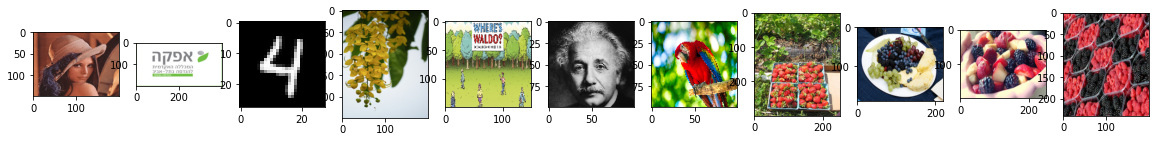

In [170]:
lena_img = read_image_from_link(link=lena_url, size=(200, 150))
afeka_img = read_image_from_link(link=afeka_url, size=(400, 200))
mnist_img = read_image_from_link(link=mnist_url, size=(28, 28))
imageNet_img = read_image_from_link(link=imageNet_url, size=(200, 250))
waldo_img = read_image_from_link(link=waldo_url, size=(150, 150))
albert_img = read_image_from_link(link=albert_url, size=(100, 100))
parrot_img = read_image_from_link(link=parrot_url, size=(100,100))
grapes_img = read_image_from_link(link=grapes_url, size=(250,300))
grapes2_img = read_image_from_link(link=grapes2_url, size=(220,190))
grapes3_img = read_image_from_link(link=grapes3_url, size=(250,200))
grapes4_img = read_image_from_link(link=grapes4_url, size=(200,240))

imgs = [lena_img, afeka_img, mnist_img, imageNet_img, waldo_img, albert_img, parrot_img, grapes_img, grapes2_img, grapes3_img, grapes4_img]
Image.show_all(imgs, ['' for i in range(len(imgs))])

# **Define Convolutional Layer using myconv function**

In [0]:
class Convolution_layer():
  def __init__(self, data, ker, s, p, n, norm=None, actv=None):
    '''
    FILTER  =   FxFxC
    INPUT   =   HxWxC
    NORM    =   None or normalized cross validation
    ACTV    =   None or RelU
    '''
    self.data     = data
    self.ker      = ker
    self.s        = s
    self.p        = p
    self.n        = n
    self.norm     = norm
    self.actv     = actv

  def forward(self):
    '''
    RETURNS output of shape: W1xH1xN
    '''
    return myconv(img=self.data, ker=self.ker, stride=self.s, p=self.p, N=self.n, Norm=self.norm, ACTV=self.actv)


# **Kernels and Filters for later**

In [0]:
"""  KERNELS AND FILTERS"""

# kernels FxF
nothing3D = np.array([[0, 0, 0],[0, 1, 0], [0, 0, 0]])
nothing5D = np.zeros((5,5))
nothing5D[2][2] = 1
nothing7D = np.zeros((7,7))
nothing7D[3][3] = 1
sobel_x = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])/5
sobel_y = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])/5
blur = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]])/9                  
blur_filter = np.ones((3, 3, 3))/27
sharpen = np.array([[-1/9,-1/9,-1/9],[-1/9,3,-1/9],[-1/9,-1/9,-1/9]])
edge_detection = np.array([[-1,-1, -1],[-1, 8, -1],[-1, -1, -1]])
up_down = np.array([[0, 1, 0],[0, 0, 0],[0, 1, 0]])
degree45_line_detector = np.array([[0, -2, -1],
                                   [2, 0, -2],
                                   [1, 2, 0]])/5
degree_minus45_line_detector = np.array([[1, 2, 0], 
                                         [2, 0, -2], 
                                         [0, -2, 1]])/(-5)
red_kernel = np.zeros((3,3))
blue_kernel = np.zeros((3,3))

# Filters FxFx3 and FxFx5 and FxFx7
blur_5D = np.ones((3, 3, 5))
identity_5D = np.zeros((3, 3, 5))
identity_5D[1][1][:] = np.ones((5))
degree_minus_45_filter = np.repeat(degree45_line_detector[:, :, np.newaxis], 3, axis=2)
degree45_filter = np.repeat(degree_minus45_line_detector[:, :, np.newaxis], 3, axis=2)
red_filter = np.repeat(red_kernel[:, :, np.newaxis], 3, axis=2)
red_filter[1][1][0] = 1
blue_filter = np.repeat(blue_kernel[:, :, np.newaxis], 3, axis=2)
blue_filter[1][1][2] = 1
identity = np.repeat(nothing3D[:, :, np.newaxis], 3, axis=2)
up_down_filter = np.repeat(up_down[:, :, np.newaxis], 3, axis=2)
sharpen_filter = np.repeat(sharpen[:, :, np.newaxis], 3, axis=2)
edge_detection_filter = np.repeat(edge_detection[:, :, np.newaxis], 3, axis=2)
blur_filter = np.repeat(blur[:, :, np.newaxis], 3, axis=2)
sobel_y_filter = np.repeat(sobel_y[:, :, np.newaxis], 3, axis=2)
sobel_x_filter = np.repeat(sobel_x[:, :, np.newaxis], 3, axis=2)
blacken_filter = np.zeros((3, 3, 3))

filters1 = [sharpen_filter, edge_detection_filter, sobel_x_filter, sobel_y_filter, red_filter]
filters2 = [degree45_filter, degree_minus_45_filter, up_down_filter, blur_filter, blue_filter]
labels1 = ["sharpen filter", "edge detection filter", "sobel_x filter", "sobel_y filter", "red filter"]
labels2 = ["degree45_filter", "degree_minus_45_filter", "up_down_blur", "box blur", "blue filter"]


def forward_10_filters_and_show(img, s, p, n, actv):
  global filters1
  global filters2
  global labels1
  global labels2

  image_set1 = []
  image_set2 = []
  for filt in FILTERS1:
    conv_layer = Convolution_layer(data=img, ker=filt, s=s, p=p, n=n, actv=actv)
    image_set1.append(conv_layer.forward()[:, :, 0])

  for filt in FILTERS2:
    conv_layer = Convolution_layer(data=img, ker=filt, s=s, p=p, n=n, actv=actv)
    image_set2.append(conv_layer.forward()[:, :, 0])

  Image.show_all(image_set1, LABELS1)
  Image.show_all(image_set2, LABELS2)

# Cascading 2 Convolutional Layers and Demonstrating the results.
Note: the first layer produces W1xH1x3 Therefore, the second filter should be FxFx3 and then goes through the 2nd layer and finaly outputs W1xH1x1

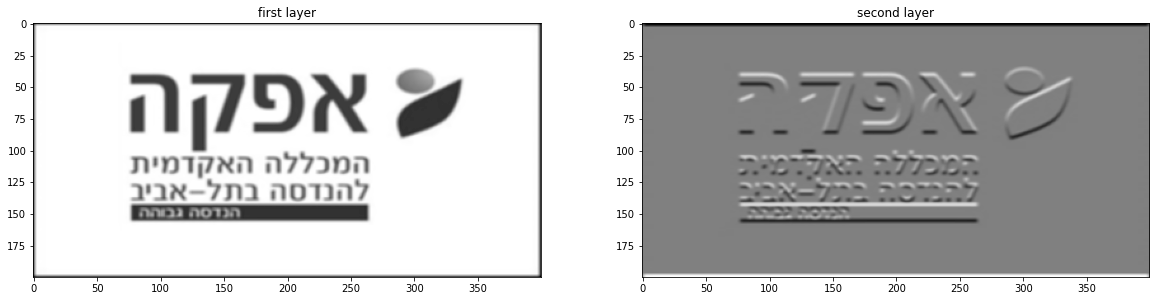

In [173]:
def cascade(img):
  conv_layer1 = Convolution_layer(data=img, ker=blur, s=1, p=1, n=3, norm=None, actv=None)
  x = conv_layer1.forward()
  rv10 = x[:,:,0]
  conv_layer2 = Convolution_layer(data=x, ker=sobel_x_filter, s=1, p=1, n=1, norm=None, actv=None)
  x = conv_layer2.forward()
  rv2 = x[:,:,0]
  Image.show_all([rv10, rv2], ['first layer','second layer'])

cascade(afeka_img)

#Convolving gray parrot Image with 3x3x3 5x5x3 7x7x3 identity filters only adjusting the padding so the output will be of the same dimention.
# All the Images are Equal which proves that the Convolution is working.

The Images are equal
The Images are equal
The Images are equal


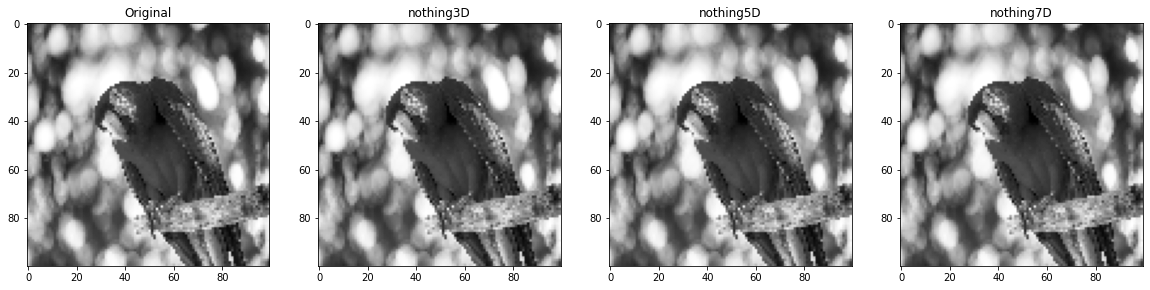

In [174]:
gray_parrot = cv2.cvtColor(parrot_img, cv2.COLOR_RGB2GRAY)

labels = ['Original', 'nothing3D', 'nothing5D', 'nothing7D']

convolved1 = myconv(img=gray_parrot, ker=nothing3D, stride=1, p=1)[:,:,0]
convolved2 = myconv(img=gray_parrot, ker=nothing5D, stride=1, p=2)[:,:,0]
convolved3 = myconv(img=gray_parrot, ker=nothing7D, stride=1, p=3)[:,:,0]
convolved = [convolved1, convolved2, convolved3]

for conv in convolved:
  equals(gray_parrot, conv)


Image.show_all([gray_parrot, convolved1, convolved2, convolved3], labels)

# Using Alberts Eye Pattern as Filter with Normalized Cross Validation and Threshholding Image to detect Matching patterns
# Note: the padding is 7 because the filter is 9x9 and I wanted the Result to be 'same' dimentions.

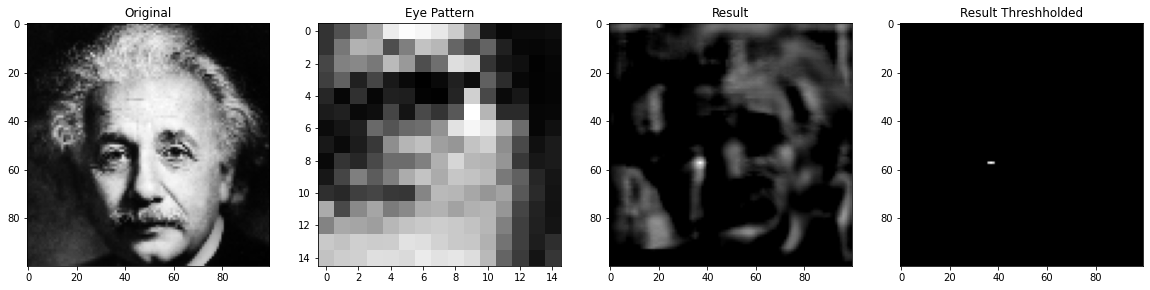

In [175]:
albert_gray = cv2.cvtColor(albert_img, cv2.COLOR_RGB2GRAY)
albert_eye_filter = albert_gray[50:65, 30:45]

convolved = myconv(img=albert_gray, ker=albert_eye_filter, stride=1, p=7, N=1, Norm=normalized_cross_validation, ACTV=relu)
convolved_gray = convolved[:, :, 0]

result = convolved_gray
thresh = threshhold(result, 0.8)
Image.show_all([albert_gray, albert_eye_filter, result, thresh], ['Original', 'Eye Pattern', 'Result', 'Result Threshholded'])

# Using Parrot Eye Pattern as Filter and Threshholding Image to detect Matching patterns
# Note: padding is 5 because the filter is 5x5 and I wanted the result to be of 'same' dimentions.

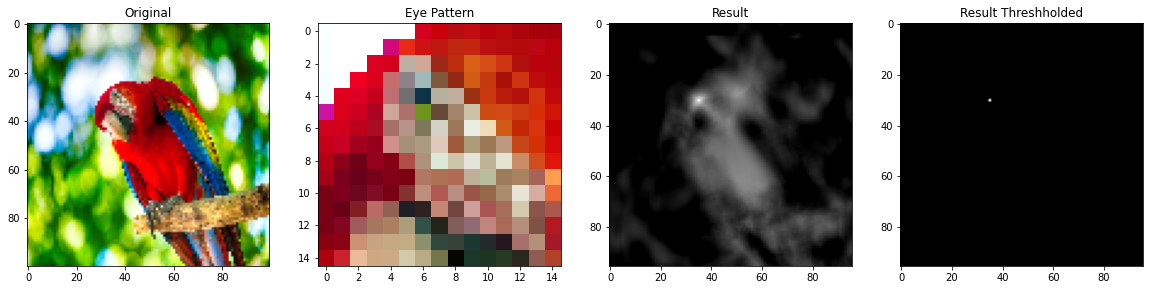

In [176]:
parrot_eye_filter = parrot_img[25:40, 30:45]

convolved = myconv(img=parrot_img, ker=parrot_eye_filter, stride=1, p=5, N=1, Norm=normalized_cross_validation, ACTV=relu)
convolved_gray = convolved[:, :, 0]

result = convolved_gray
thresh = threshhold(result, 0.8)

Image.show_all([parrot_img, parrot_eye_filter, result, thresh], ['Original', 'Eye Pattern', 'Result', 'Result Threshholded'])

# An Example of Bad Hyper-parameters
We can't even see that the digit is '4'

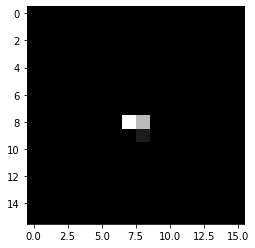

In [177]:
convolved = myconv(img=mnist_img, ker=sharpen_filter, stride=8, p=50, N=1, Norm=None, ACTV=None)
convolved_gray = convolved[:, :, 0]
Image.show(convolved_gray)

# **Operating N=10 Filters on the same Image with different hyper-parameters using the Convolutional Layer I made.**

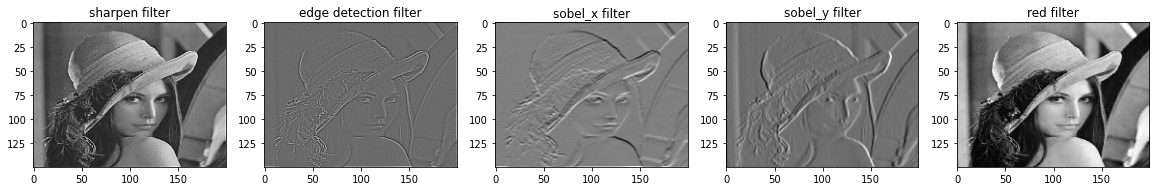

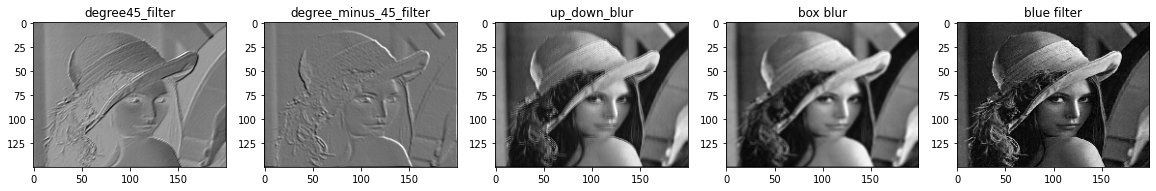

In [178]:
forward_10_filters_and_show(img=lena_img, s=1, p=1, n=1, actv=None)

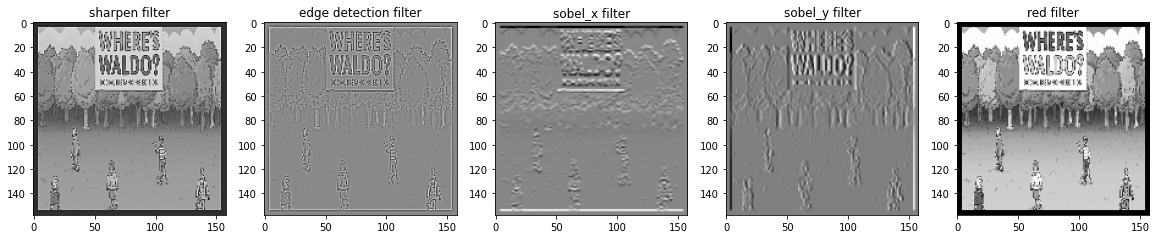

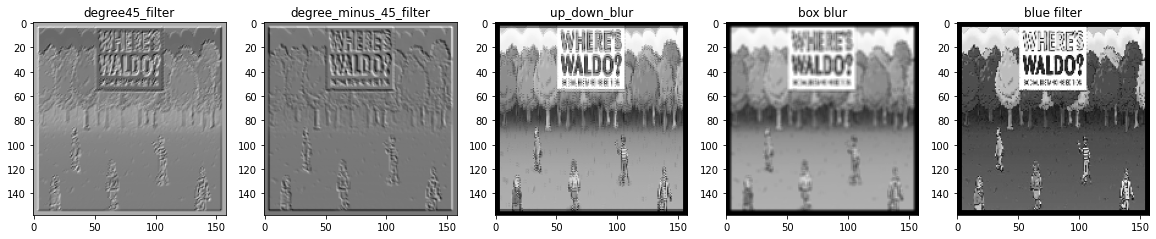

In [179]:
forward_10_filters_and_show(img=waldo_img, s=1, p=5, n=1, actv=None)

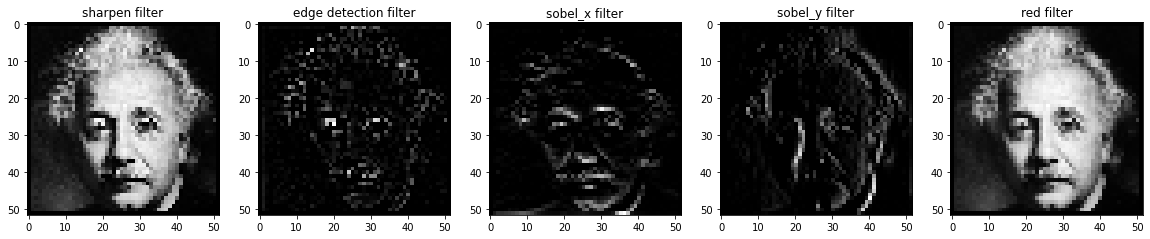

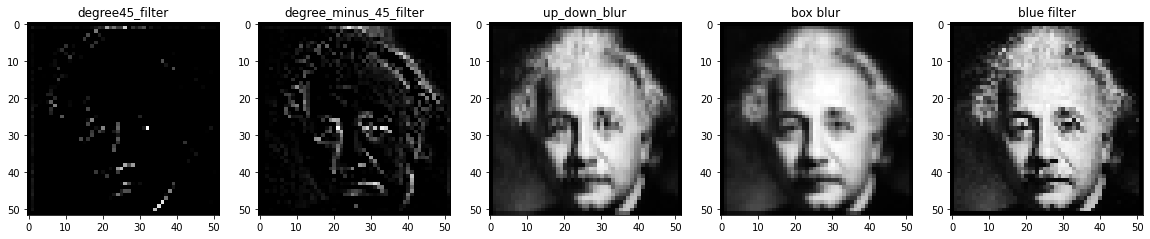

In [180]:
forward_10_filters_and_show(img=albert_img, s=2, p=3, n=1, actv=relu)

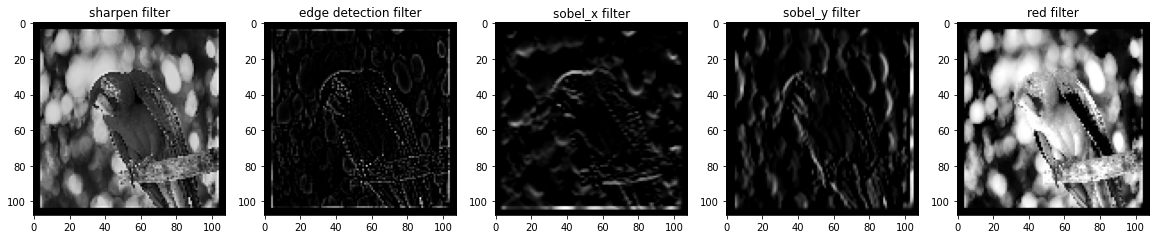

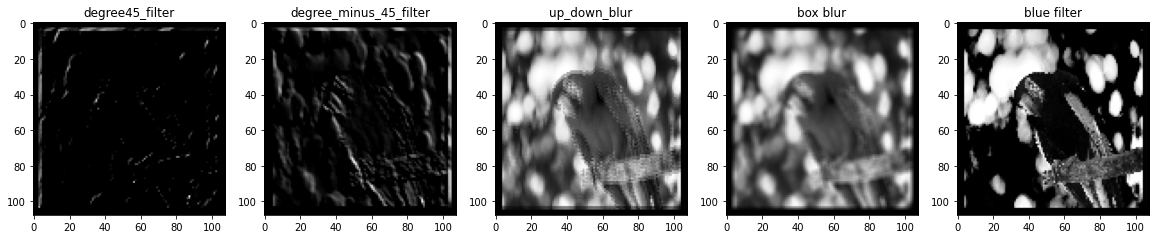

In [181]:
forward_10_filters_and_show(img=parrot_img, s=1, p=5, n=1, actv=relu)

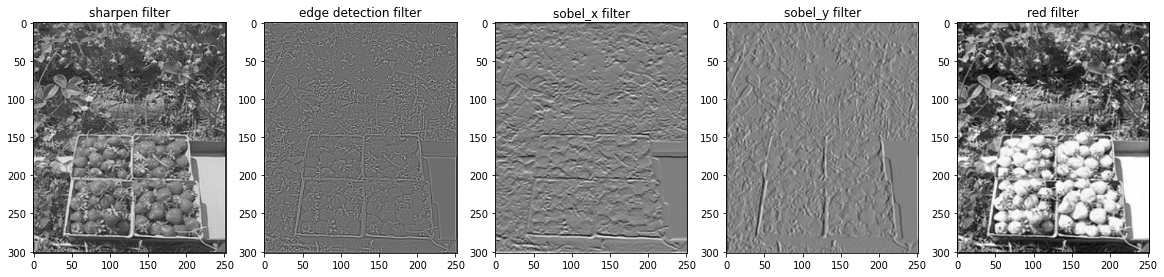

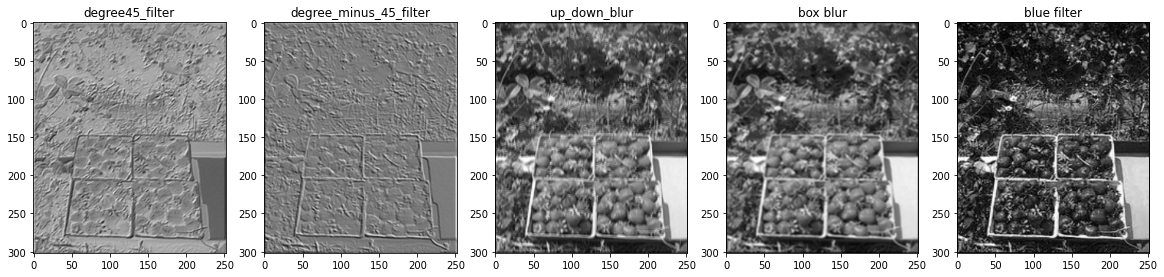

In [182]:
forward_10_filters_and_show(img=grapes_img, s=1, p=2, n=1, actv=None)

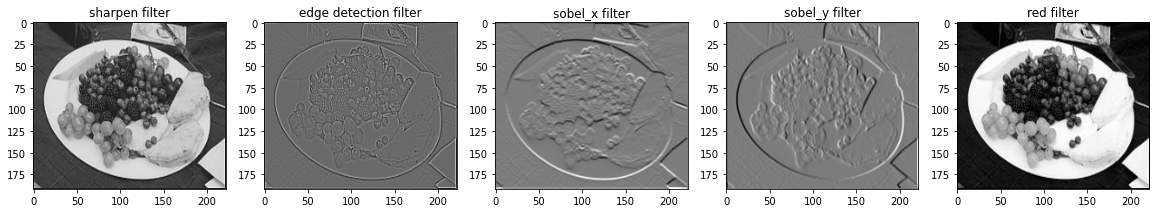

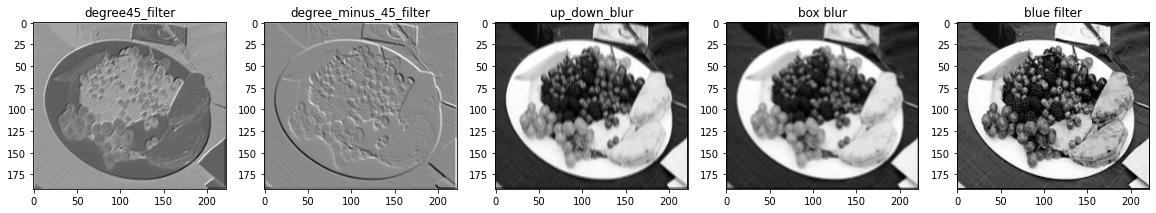

In [183]:
forward_10_filters_and_show(img=grapes2_img, s=1, p=2, n=1, actv=None)

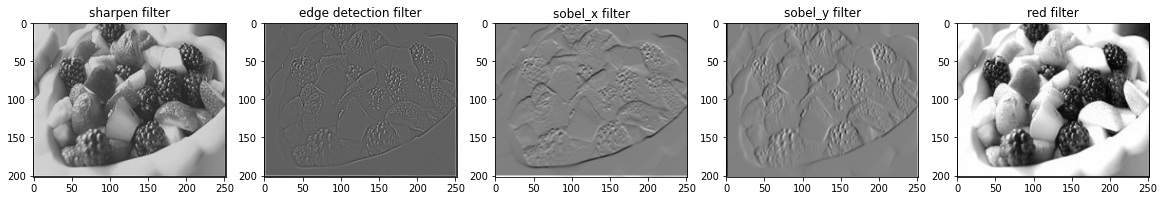

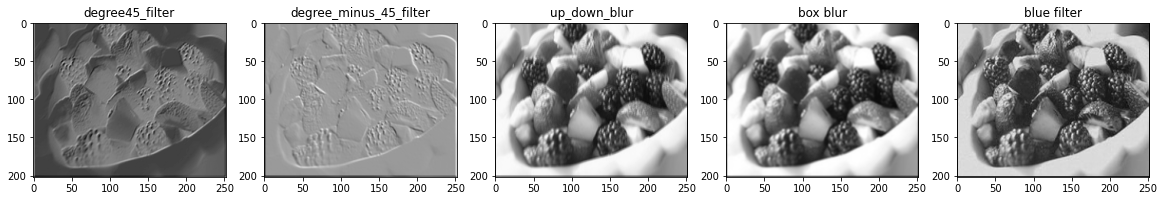

In [184]:
forward_10_filters_and_show(img=grapes3_img, s=1, p=2, n=1, actv=None)